# Tutorial 5 - FOSWEC

Novel things in this tutorial
* Creating a WEC from Impedance DAta
* MUlti-dof saturated PI controller

In [30]:
import scipy.io
import matplotlib.pyplot as plt
import autograd.numpy as np

import wecopttool as wot
from xarray import DataArray


## 1. Model setup



### 1.1 Preprocessing data

We start with loading the FOSWEC impedance data (matlab format) [XX link]
and add metadata to utilize the enhanced capabilities of xarrays

In [31]:
foswec_data = scipy.io.loadmat('data/foswec_model.mat')
Zi_data = foswec_data['Zi']
H_data = foswec_data['Hex']
freq_data = foswec_data['f']
omega_data = freq_data * 2*np.pi
dof_names = ["Aft","Bow"]
dof_attr = {'long_name': 'Degree of freedom'}
freq_attr = {'long_name': 'Wave frequency', 'units': 'rad/s'}
dims_imp = ('radiating_dof', 'influenced_dof', 'omega')
coords_imp = [(dims_imp[0], dof_names, dof_attr),
          (dims_imp[1], dof_names, dof_attr),
          (dims_imp[2], np.squeeze(omega_data), freq_attr),]
attrs_imp = {'units': 'Ns/m', 'long_name': 'Intrinsic Impedance'} 

intrinsic_impedance_data = DataArray(Zi_data, dims = dims_imp, coords = coords_imp,
                                        attrs=attrs_imp, name='Intrinsic impedance')

dir_attr = {'long_name': 'Wave direction', 'units': 'rad'}
directions = np.atleast_1d(0.0)
ndirections = len(directions)
exc_c = np.transpose(H_data)
exc_c = np.expand_dims(exc_c, axis = [1])

dims_exc = ('omega', 'wave_direction', 'influenced_dof')

coords_exc = [(dims_exc[0], np.squeeze(omega_data), freq_attr), 
          (dims_exc[1], directions, dir_attr),
          (dims_exc[2], dof_names, dof_attr)]

attrs_exc = {'units': 'N/m', 'long_name': 'Excitation Coefficient'} 

exc_coeff_data = DataArray(exc_c, dims=dims_exc, coords=coords_exc,
                        attrs=attrs_exc, name='excitation coefficient') 

In [32]:
# TODO: replace with wot.utils functions once PRed
def plot_bode_intrinsic_impedance(impedance: DataArray, title: str):
    """Plot Bode graph from wecoptool impedance data array.

    Parameters
    ----------
    impedance: DataArray
        Complex intrinsic impedance matrix produced by
        :py:func:`wecopttool.hydrodynamic_impedance`.
        Dimensions: omega, radiating_dofs, influenced_dofs


    """
    radiating_dofs = impedance.radiating_dof.values
    influenced_dofs = impedance.influenced_dof.values
    mag = 20.0 * np.log10(np.abs(impedance))
    # phase = np.rad2deg(np.unwrap(np.angle(impedance)))    #unwrap creates all nan if nan is in data
    phase = np.rad2deg(np.angle(impedance))
    freq = impedance.omega.values/2/np.pi   
    fig, axes = plt.subplots(2*len(radiating_dofs), len(influenced_dofs),
                                tight_layout=True, sharex=True, 
                                figsize=(3*len(radiating_dofs), 2*len(influenced_dofs)), squeeze=False)
    fig.suptitle(title + ' Bode Plots \n Mag (dB), Phase (deg)', fontweight='bold')

    sp_idx = 0
    for i, rdof in enumerate(radiating_dofs):
        for j, idof in enumerate(influenced_dofs):
            sp_idx += 1
            axes[2*i, j].semilogx(freq, mag[i, j, :])    # Bode magnitude plot
            axes[2*i+1, j].semilogx(freq, phase[i, j, :])    # Bode phase plot
            axes[2*i, j].grid(True, which = 'both')
            axes[2*i+1, j].grid(True, which = 'both')

            if i == len(radiating_dofs)-1:
                axes[2*i+1, j].set_xlabel(f'Frequency (Hz)', fontsize=10)
            else:
                axes[i, j].set_xlabel('')
            if j == 0:
                axes[2*i, j].set_ylabel(f'{rdof} \n Mag. (dB)', fontsize=10)
                axes[2*i+1, j].set_ylabel(f'Phase. (deg)', fontsize=10)
            else:
                axes[i, j].set_ylabel('')
            if i == 0:
                axes[i, j].set_title(f'{idof}', fontsize=10)
            else:
                axes[i, j].set_title('')

In [33]:
f1 = 0.025 # Hz
nfreq = 75

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
omega = freq*2*np.pi

In [34]:
exc_coeff_intrp = exc_coeff_data.interp(omega = omega, method='linear', kwargs={"fill_value": "extrapolate"})
intrinsic_impedance_intrp = intrinsic_impedance_data.interp(omega = omega, kwargs={"fill_value": "extrapolate"})

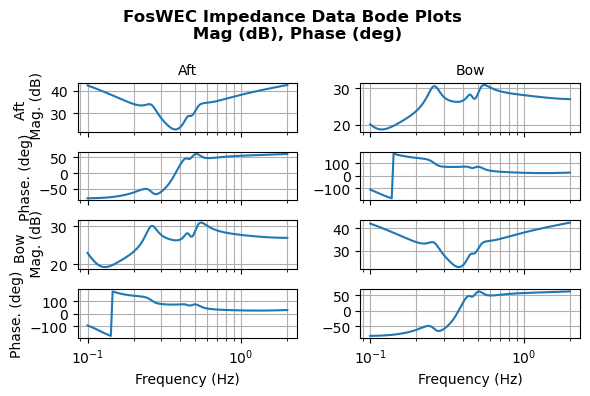

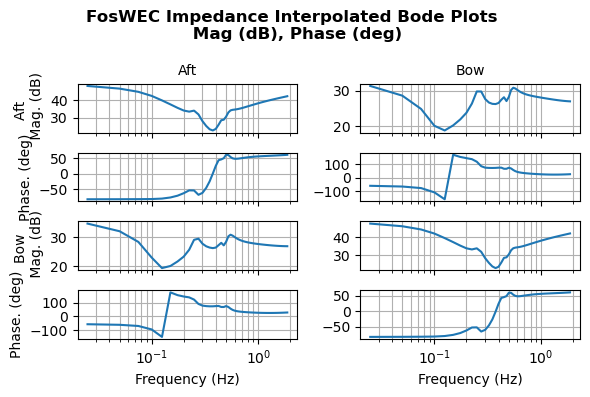

In [35]:
plot_bode_intrinsic_impedance(intrinsic_impedance_data, 'FosWEC Impedance Data')
plot_bode_intrinsic_impedance(intrinsic_impedance_intrp, 'FosWEC Impedance Interpolated')

### 1.3 PTO


In [36]:
ndof = len(dof_names)

In [37]:
## Impedance
gear_ratio = 3.75
torque_constant = 0.943
winding_resistance = 1.082
winding_inductance = 0.0
drivetrain_inertia = 0.2
drivetrain_friction = 0.2
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        1/(1j*omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance

zeros = np.zeros(omega.shape)
pto_impedance = np.array([[pto_impedance_11, zeros, pto_impedance_12, zeros],
                    [zeros, pto_impedance_11, zeros, pto_impedance_12],
                    [pto_impedance_21, zeros, pto_impedance_22, zeros],
                    [zeros, pto_impedance_21, zeros, pto_impedance_22]])

In [38]:
f_max = 20.0
def saturated_pi(pto, wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td_tmp = wot.pto.controller_pi(pto, wec, x_wec, x_opt, waves, nsubsteps)
    force_td = np.clip(force_td_tmp, -1*f_max, f_max)
    return force_td
    # return force_td_tmp

In [39]:
   # Set PTO object
pto_dof = ndof
name = ["PTO_Aft","PTO_Bow"]
kinematics = np.eye(ndof)
loss = None
# controller = wot.pto.controller_pi
controller = saturated_pi

pto = wot.pto.PTO(pto_dof, kinematics, controller, pto_impedance, loss, name)

f_add = {'PTO': pto.force_on_wec}

In [40]:
#TODO: calculate actual HS
hydrostatic_stiffness = np.zeros((ndof,ndof))

In [41]:
wec = wot.WEC.from_impedance(freq,
    intrinsic_impedance_intrp,
    exc_coeff_intrp,
    hydrostatic_stiffness,
    f_add
)

In [42]:
# Waves
wfreq = 0.2
amplitude = 0.2
phase = -40
waves = wot.waves.regular_wave(f1, nfreq, wfreq, amplitude, phase)

assert(7*wfreq<f1*nfreq)

In [43]:
# Objective function
obj_fun = pto.average_power
nstate_opt = 2*ndof
options = {'maxiter': 300, 'ftol': 1e-6, 'disp' : True}

# Solve
scale_x_wec = 1e0  
scale_x_opt = 1e-3  
scale_obj = 1e3  
res = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    optim_options = options)


Iteration limit reached    (Exit mode 9)
            Current function value: 59860.114639012274
            Iterations: 300
            Function evaluations: 3276
            Gradient evaluations: 300


In [44]:
# Post-process
nsubstep_postprocess = 4
wec_fdom, wec_tdom = wec.post_process(res, waves, nsubstep_postprocess)
pto_fdom, pto_tdom = pto.post_process(wec, res, waves, nsubstep_postprocess)

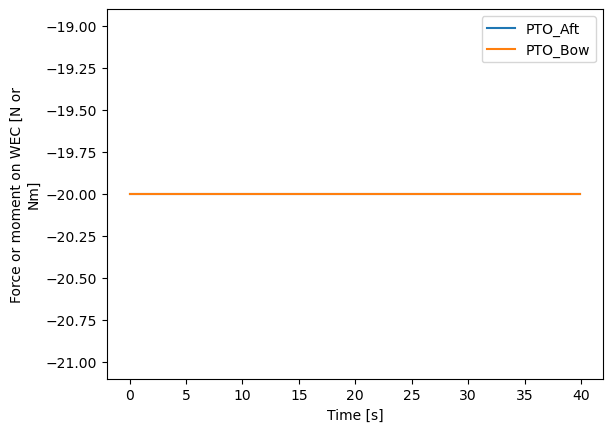

In [45]:
for name_pto_dof in pto_tdom.dof.values:
    pto_tdom.force.sel(dof = name_pto_dof).plot(label = name_pto_dof)
    
plt.title('')
plt.legend()

In [46]:
x_wec, x_opt = wot.decompose_state(res.x, ndof, nfreq)
force_td_tmp = wot.pto.controller_pi(pto, wec, x_wec, x_opt, waves, nsubsteps=1)
np.clip(force_td_tmp, -1*f_max, f_max)


array([[-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20., -20.],
       [-20.,